<a href="https://colab.research.google.com/github/TuringCollegeSubmissions/ggedvi-DL.4.1/blob/master/02_DL_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIBRARIES

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install contractions

In [ ]:
pip install lime

In [ ]:
pip install pytorch_lightning

In [ ]:
pip install optuna

In [3]:
from matplotlib.pylab import plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import os

import nltk

from collections import Counter

from tqdm import tqdm

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import random
import joblib
import utils

import nltk

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.nn import Sigmoid
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import optuna
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
from transformers.optimization import get_linear_schedule_with_warmup
import pytorch_lightning as pl
import pickle
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 10000, "display.max_columns", 10)
print("Setup complete")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Setup complete


For this assignment I will use the Distilbert model and DistilBertTokenizer as tokenizer.
The work plan is:<br>
    * preprocess given dataset;<br>
    * tokenize text using DistilBertTokenizer; <br>
    * the network will have the DistilBERT model. Follwed by a Droput and Linear Layer. They are for Regulariaztion and Classification.<br>
    * Final model layer outputs is what will be used to calculate the loss and to get the accuracy of prediction.<br>
    * The trained model will be saved at its best validation dataset loss value.<br>
    * The loss function used will be a combination of Binary Cross Entropy which is implemented as BCELogits Loss in PyTorch;<br>
    * Optimizer AdamW is used to update the weights of the neural network to improve its performance.<br>
    * Schedule with a constant learning rate preceded by a warmup period during which the learning rate increases linearly between 0 and the initial lr set in the optimizer.<br>
    * Since it is binomial classification I will use a Sigmoid activation to the output layer for each output to have independent probability. That will be also useful for model explainability.

In [4]:
true_news_path = "/content/drive/MyDrive/News_data/True.csv"
fake_news_path = "/content/drive/MyDrive/News_data/Fake.csv"
true_df = pd.read_csv(true_news_path, encoding="utf-8")
true_df["type"] = 1
fake_df = pd.read_csv(fake_news_path, encoding="utf-8")
fake_df["type"] = 0

df = pd.concat([true_df, fake_df], axis=0)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)

df.head()

title  \
0  DISASTER CAPITALISTS: How Bill And Hillary’s “...   
1  Highlights: The Trump presidency on January 27...   
2  HEARTBROKEN WOMAN IN TEARS After Boston Antifa...   
3  Texas House passes 'bathroom bill' targeting p...   
4   ‘I’m Not A Racist’: Trump Campaign Official B...   

                                                text          subject  \
0  Hillary was Secretary of State an unimaginable...  Government News   
1  (Reuters) - Highlights of the day for U.S. Pre...     politicsNews   
2  In case you missed this earlier today A woman ...         politics   
3   (This version of the May 22 story was correct...     politicsNews   
4  Carl Paladino, who served as the co-chairman o...             News   

                date  type  
0        Oct 7, 2016     0  
1  January 27, 2017      1  
2       Aug 19, 2017     0  
3      May 22, 2017      1  
4  December 27, 2016     0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   type     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
preprocessing_steps = [
    ("filter_df_by_date_pattern", utils.filter_df_by_date_pattern),
    (
        "drop_rows_with_empty_or_whitespace_cells",
        utils.drop_rows_with_empty_or_whitespace_cells,
    ),
    ("drop_duplicate_rows_by_column", utils.drop_duplicate_rows_by_column),
    ("exclude_before_reuters", utils.exclude_before_reuters),
    ("concat_title", utils.concat_title),
    ("remove_html_tags", utils.remove_html_tags),
    ("remove_non_ascii", utils.remove_non_ascii),
    ("remove_special_characters", utils.remove_special_characters_dl),
    ("lower case", utils.process_lower_case_dl),
]

def preprocess_with_progress(df):
    processed_functions = []
    for step_name, step_func in tqdm(preprocessing_steps, desc="Preprocessing"):
        df = step_func(df)
    return df

preprocessor = FunctionTransformer(preprocess_with_progress)

preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

df = preprocessing_pipeline.fit_transform(df)

Preprocessing: 100%|██████████| 9/9 [42:49<00:00, 285.47s/it]


In [ ]:
df.head()

text       subject  type
0  EU   commission   may   launch   moves   to   ...     worldnews     1
1  india   cenbank   says   linking   national   ...     worldnews     1
2  religious   left   emerging   as   US   politi...  politicsNews     1
6  carson   cancels   campaign   events   after  ...  politicsNews     1
7  SHOCKING   RAW   VIDEO   OF   ALEXANDRIA   SHO...      politics     0

(0.0, 512.0)

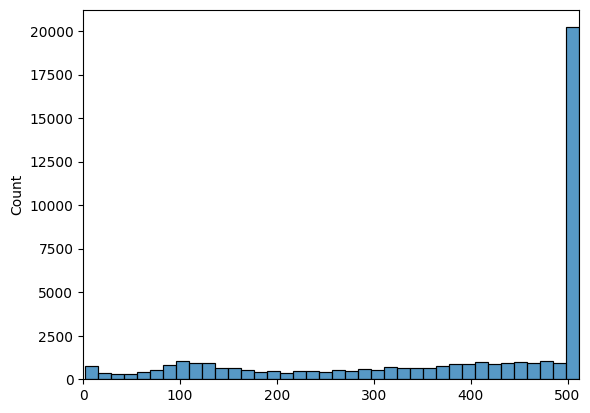

In [ ]:
MODEL_NAME = "distilbert-base-cased"
TOKENIZER = DistilBertTokenizer.from_pretrained(MODEL_NAME)

token_counts = []
for _, row in df.iterrows():
    token_count = len(
        TOKENIZER.encode(row["text"], max_length=512, truncation=True)
    )
    token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512])

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.text
sample_labels = int(sample_row.type)

encoding = TOKENIZER.encode_plus(
    sample_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
)
print(encoding.keys())
print(sample_comment)
print(sample_labels)

dict_keys(['input_ids', 'attention_mask'])
watch   donald   trump   hilariously   push   cruz   to   booze   on   the   tonight   show   VIDEO   with   all   the   candidates   from   both   parties   in   new   york   preparing   for   the   primary   next   tuesday   it   s   no   surprise   that   they   are   making   the   late   night   talk   show   rounds   appearing   on   the   tonight   show   with   jimmy   fallon   ted   cruz   got   a   call   from   donald   trump   offering   him   advice   for   the   show   appearance   and   questioning   him   about   some   of   his   policy   positionsas   crazy   as   cruz   is   the   sketch   actually   turned   out   pretty   funny   with   digs   being   taken   at   both   the   GOP   candidates   one   of   the   funniest   moments   was   when   cruz   mentioned   that   the   party   is   starting   to   unify   behind   him   yet   trump   cut   in   to   remind   cruz   that   the   party   is   also   unifying   behind

* The result of the encoding is a dictionary with token ids input_ids and an attention mask attention_mask

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,  2824,  1274, 18728,   189, 27321, 20844,  5815, 15160,  4684,
          172,  5082,  1584,  1106,   171,  5658,  3171,  1113,  1103,  3568])

In [ ]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

* Also we can get back the words from the token ids:

In [ ]:
print(TOKENIZER.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'watch', 'don', '##ald', 't', '##rump', 'hi', '##lar', '##iously', 'push', 'c', '##ru', '##z', 'to', 'b', '##oo', '##ze', 'on', 'the', 'tonight']


# DL Model

* Model chosen: Distilbert (base-cased);
* Tokenizer: DistilBertTokenizer;
* Added layers: Linear(768, 768), Dropout(0.2), Linear(768, 1);
* Optimizer: AdamW;
* Loss: BCEWithLogitsLoss(weight=class_weights_tensor): after preprocessing we have imbalanced data and calculated weight was added in attempt to balance it.
* Activation: Sigmoid.

* after tokenization presentation I will prepare dataset for modeling part:

In [ ]:
df.head()

title  \
0  Pro-business Sessions will not go easy on corp...   
1   Neil deGrasse Tyson Just Went NUCLEAR On Twit...   
2  U.S. climate envoy Stern to step down: State D...   
3   New Dramatic Poll Shows Just How Much Trump H...   
4  South Korea's Moon unveils new focus on Southe...   

                                                text                date  type  
0  (Reuters) - Jeff Sessions may be known as a pr...  November 19, 2016      1  
1  Astrophysicist Neil deGrasse Tyson is NOT a fa...      March 22, 2017     0  
2  WASHINGTON (Reuters) - U.S. climate envoy Todd...     March 21, 2016      1  
3  Before Donald Trump stepped foot in the White ...      August 2, 2017     0  
4  BOGOR, Indonesia (Reuters) - South Korean Pres...   November 9, 2017      1

* We saw in the plot that token number exceeds 500 tokens. Threfore I need to take maximum tokens as 512:

In [5]:
MAX_TOKEN_LEN = 512
N_EPOCHS = 10
BATCH_SIZE = 8
MODEL_NAME = 'distilbert-base-cased'
TOKENIZER = DistilBertTokenizer.from_pretrained(MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-5

* splitting dataset into 3 parts: train, validation and test datasets:

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["type"])
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["type"]
)
train_df.shape, val_df.shape, test_df.shape

((35918, 5), (4490, 5), (4490, 5))

* Display the distribution of the target variable in each dataset

In [ ]:
train_ratios = train_df['type'].value_counts(normalize=True)
val_ratios = val_df['type'].value_counts(normalize=True)
test_ratios = test_df['type'].value_counts(normalize=True)

print("Train Ratios:")
print(train_ratios)
print("\nValidation Ratios:")
print(val_ratios)
print("\nTest Ratios:")
print(test_ratios)

Train Ratios:
type
0    0.522997
1    0.477003
Name: proportion, dtype: float64

Validation Ratios:
type
0    0.52294
1    0.47706
Name: proportion, dtype: float64

Test Ratios:
type
0    0.52294
1    0.47706
Name: proportion, dtype: float64


* **Note**: Data preprocessing was not as drastic as in ML preprocessing. I have left personalities, weekdays, because the idea behind this was to keep data as 'human' as possible to allow Distilbert to process the importance of each feature with dataset biases as this would be the 'real' life situation.

In [7]:
preprocessing_steps = [
    ("filter_df_by_date_pattern", utils.filter_df_by_date_pattern),
    (
        "drop_rows_with_empty_or_whitespace_cells",
        utils.drop_rows_with_empty_or_whitespace_cells,
    ),
    ("drop_duplicate_rows_by_column", utils.drop_duplicate_rows_by_column),
    ("exclude_before_reuters", utils.exclude_before_reuters),
    ("concat_title", utils.concat_title),
    ("remove_html_tags", utils.remove_html_tags),
    ("remove_non_ascii", utils.remove_non_ascii),
    ("remove_special_characters", utils.remove_special_characters_dl),
    ("lower case", utils.process_lower_case_dl),
]

In [8]:
class Fake_Dataset(Dataset):
    def __init__(self, df, tokenizer, target_column, max_token_len=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.target_column = target_column

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        df_row = self.df.iloc[index]
        text = df_row.text
        labels = torch.tensor(float(df_row.type), dtype=torch.float32)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            truncation=True,
            padding="max_length",
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(labels, dtype=torch.float32),
        }

In [9]:
class FakeDataloader(pl.LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
        test_df,
        tokenizer,
        batch_size=8,
        max_token_len=512,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

        self.train_df = self.preprocess_data(train_df)
        self.val_df = self.preprocess_data(val_df)
        self.test_df = self.preprocess_data(test_df)

    def collate_fn(self, batch):
        input_ids = [item["input_ids"] for item in batch]
        attention_masks = [item["attention_mask"] for item in batch]
        labels = [item["labels"] for item in batch]

        input_ids = pad_sequence(
            input_ids,
            batch_first=True,
            padding_value=self.tokenizer.pad_token_id,
        )
        attention_masks = pad_sequence(
            attention_masks, batch_first=True, padding_value=0
        )
        labels = torch.stack(labels)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_masks,
            "labels": labels,
        }

    def preprocess_data(self, df):
        """Apply preprocessing steps to the DataFrame"""
        for step_name, step_func in tqdm(
            preprocessing_steps, desc="Preprocessing"
        ):
            df = step_func(df)
        return df

    def setup(self, stage):
        if stage == "fit":
            self.train_dataset = Fake_Dataset(
                self.train_df,
                self.tokenizer,
                self.train_df["type"],
                self.max_token_len,
            )

            self.val_dataset = Fake_Dataset(
                self.val_df,
                self.tokenizer,
                self.val_df["type"],
                self.max_token_len,
            )

        if stage in (None, "test", "predict"):
            self.test_dataset = Fake_Dataset(
                self.test_df,
                self.tokenizer,
                self.test_df["type"],
                self.max_token_len,
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            collate_fn=self.collate_fn,
        )

In [10]:
class FakeDetectionModel(pl.LightningModule):
    def __init__(
        self,
        n_training_steps=None,
        n_warmup_steps=None,
        config=None,
        class_weights=None,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.model = DistilBertModel.from_pretrained(
            MODEL_NAME, return_dict=True
        )
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        if class_weights is None:
            class_weights = compute_class_weight(
                "balanced", classes=[0, 1], y=train_df["type"]
            )
        class_weight_1 = class_weights[1]
        class_weights_tensor = torch.tensor(class_weight_1, dtype=torch.float32)
        self.criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits.squeeze(1)

    def shared_step(self, batch):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"].float()
        input_ids = input_ids.to(torch.long)
        logits = self.forward(input_ids, attention_mask)
        probabilities = torch.sigmoid(logits)
        loss = self.criterion(logits, labels)
        return loss, logits

    def training_step(self, batch, batch_idx):
        loss, _ = self.shared_step(batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, _ = self.shared_step(batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, _ = self.shared_step(batch)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-06
        )
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps,
        )
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(scheduler=scheduler, interval="step"),
        )
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
        print("Model parameters frozen")

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True
        print("Model parameters unfrozen")

    def count_trainable_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

This is an instance to the created data loading module:

In [ ]:
data_container = FakeDataloader(
    train_df,
    val_df,
    test_df,
    tokenizer=TOKENIZER,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_LEN,
)


Preprocessing: 100%|██████████| 9/9 [49:12<00:00, 328.10s/it]

Preprocessing: 100%|██████████| 9/9 [10:57<00:00, 73.04s/it]

Preprocessing: 100%|██████████| 9/9 [10:59<00:00, 73.28s/it]


In [ ]:
# Save the data_container object
with open('/content/drive/MyDrive/data/data_container.pkl', 'wb') as f:
    pickle.dump(data_container, f)

In [11]:
# Load the saved data_container object
with open('/content/drive/MyDrive/data/data_container.pkl', 'rb') as f:
    data_container = pickle.load(f)

In [12]:
train_df = data_container.train_df
val_df = data_container.val_df
test_df = data_container.test_df

* To use the scheduler, we need to calculate the number of training and warm-up steps.

In [13]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

steps_per_epoch, total_training_steps

(3547, 35470)

* Creating checkpoint that saves the best model (based on validation loss);
* adding logger to follow progress;
* also early stopping with patience = 2.

In [15]:
checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/checkpoints",
    filename="best_fake_checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)
logger = TensorBoardLogger(
    "/content/drive/MyDrive/fake_logs", name="fake_detection"
)
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

* Now I make instance to the model:

In [16]:
trainer = pl.Trainer(
  accelerator="gpu",
  devices=1,
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  gradient_clip_val=1,
  enable_progress_bar=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


* **Note:** the very first attempt was to try out technique described in the internet forums:
- first use a pretrained model for efficient training with added layers;
- second even though the whole model need not be trained from scratch it still needs some tweak. Thats why we unfreeze the model and train for a little longer for better results.
So this is first attempt to check this theory:

In [ ]:
epochs_to_freeze = 2
epochs_to_unfreeze = 6
total_epochs = epochs_to_freeze + epochs_to_unfreeze

model = FakeDetectionModel(
    n_warmup_steps=steps_per_epoch,
    n_training_steps=total_training_steps,
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=total_epochs,
    gradient_clip_val=1,
    enable_progress_bar=True
)
for epoch in range(total_epochs):
    if epoch < epochs_to_freeze:
        model.freeze()
    else:
        model.unfreeze()

    trainer.fit(model, data_container)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
591 K     Trainable params
65.2 M    Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Model parameters frozen


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 3548: 'val_loss' reached 0.53238 (best 0.53238), saving model to '/content/drive/MyDrive/checkpoints/best_fake_checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 7096: 'val_loss' reached 0.43996 (best 0.43996), saving model to '/content/drive/MyDrive/checkpoints/best_fake_checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 10644: 'val_loss' reached 0.38332 (best 0.38332), saving model to '/content/drive/MyDrive/checkpoints/best_fake_checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 14192: 'val_loss' reached 0.34469 (best 0.34469), saving model to '/content/drive/MyDrive/checkpoints/best_fake_checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 17740: 'val_loss' reached 0.32311 (best 0.32311), saving model to '/content/drive/MyDrive/checkpoints/best_fake_checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 21288: 'val_loss' reached 0.30419 (best 0.30419), saving model to '/content/drive/MyDrive/checkpoints/best_fake_checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 24836: 'val_loss' reached 0.29125 (best 0.29125), saving model to '/content/drive/MyDrive/checkpoints/best_fake_checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 28384: 'val_loss' reached 0.28413 (best 0.28413), saving model to '/content/drive/MyDrive/checkpoints/best_fake_checkpoint-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
591 K     Trainable params
65.2 M    Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Model parameters frozen


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
65.8 M    Trainable params
0         Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Model parameters unfrozen


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
65.8 M    Trainable params
0         Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Model parameters unfrozen


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
65.8 M    Trainable params
0         Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Model parameters unfrozen


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
65.8 M    Trainable params
0         Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Model parameters unfrozen


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
65.8 M    Trainable params
0         Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Model parameters unfrozen


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
65.8 M    Trainable params
0         Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Model parameters unfrozen


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


In [37]:
directory_path = "/content/drive/MyDrive/checkpoints"
best_model_filename = "best_fake_checkpoint.ckpt"
best_model_path = os.path.join(directory_path, best_model_filename)

In [38]:
trained_model = FakeDetectionModel.load_from_checkpoint(
    best_model_path, n_classes=1
)
trained_model.eval()
trained_model.freeze()

Model parameters frozen


In [39]:
trainer.test(trained_model, data_container)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3069051504135132     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3069051504135132}]

* code to load saved model:

* Printing out classification report and confusion matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2189
           1       0.94      0.85      0.89      2138

    accuracy                           0.90      4327
   macro avg       0.90      0.90      0.90      4327
weighted avg       0.90      0.90      0.90      4327



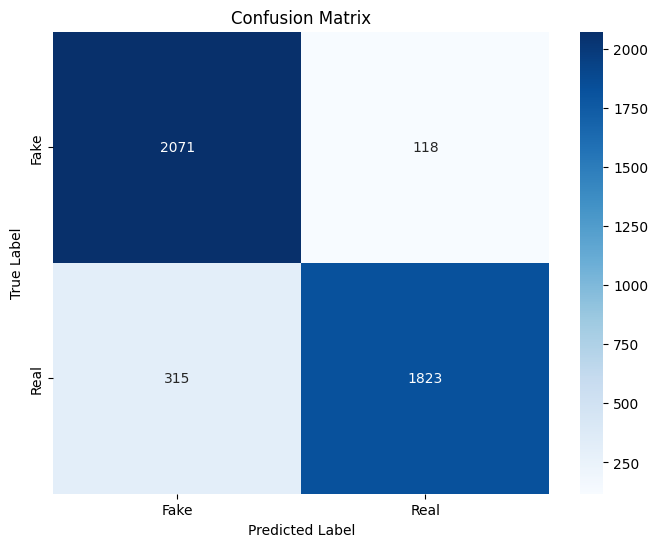

In [41]:
test_predictions = []
true_labels = []
for i in range(len(test_df)):
    test_text = test_df["text"].iloc[i]
    encoding = TOKENIZER.encode_plus(
        test_text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    trained_model = trained_model.to(device)
    test_prediction = (
        trained_model(input_ids, attention_mask).detach().cpu().numpy()
    )
    test_predictions.append(test_prediction)
    true_label = test_df["type"].iloc[i]
    true_labels.append(true_label)

test_predictions = np.array(test_predictions)
true_labels = np.array(true_labels)

print("Classification Report:")
print(classification_report(true_labels, (test_predictions > 0.5).astype(int)))

cm = confusion_matrix(true_labels, (test_predictions > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

* **Note**: compared with Logistic Regression results False Negative result is better with much better prediction result for negative (False_news) class f1: 91%.

* Checking model performance on single instance and also LIME:

In [25]:
random_index = 654

test_text = test_df['text'].iloc[random_index]
real_label = test_df['type'].iloc[random_index]

In [27]:
encoding = TOKENIZER.encode_plus(
    test_text,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
    truncation =True,
)
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)
test_prediction = trained_model(input_ids, attention_mask)
probability = torch.sigmoid(test_prediction).item()

threshold = 0.5
predicted_label = 1 if probability > threshold else 0

print(test_text)
print("Real Label:", real_label)
print("Predicted Label:", predicted_label)

stevehilton   rips   the   patronizing   world   leaders   for   their   criticism   of   trump   video   steve   hilton   rips   the   great   geniuses   on   foreign   policy   who   are   patronizing   the   way   president   trump   speaks   he   says   THEY   are   the   ones   who   left   the   world   in   a   mess!   amen!!!hilton   couldn   t   be   more   dead   on   in   his   assessment   of   the   globalist   attempt   at   a   new   world   order   that   trump   just   stopped   these   leaders   are   responsible   for   korea   iran   and   the   entire   middle   east   mess   hello   hillary   clinton!   she   and   her   husband   have   been   whoring   around   the   world   grabbing   up   anything   they   can   to   amass   a   fortune   off   the   backs   of   the   american   people   obama   did   NOTHING   on   foreign   policy   accept   to   apologize   to   our   enemies   his   entire   8   years   in   office   remember   the   apology   tour   the 

In [115]:
def predict_proba(texts):
    inputs = TOKENIZER(
        texts,
        return_tensors="pt",
        max_length=512,
        padding=True,
        truncation=True,
    )
    trained_model.eval()
    with torch.no_grad():
        y_pred = trained_model(**inputs)
        y_pred_negative = 1 - y_pred
        y_pred = y_pred.unsqueeze(1)
        y_pred_negative = y_pred_negative.unsqueeze(1)
        y_pred_concat = torch.cat((y_pred_negative, y_pred), dim=1)
    probabilities = torch.softmax(y_pred_concat, dim=1)
    return probabilities.cpu().numpy()

In [33]:
explainer = LimeTextExplainer(class_names=["Fake_News", "Real_News"])
trained_model.cpu()
exp = explainer.explain_instance(test_text, predict_proba, num_features=3)
probabilities = predict_proba(test_text)
print("Probability(fake news) =", probabilities[0, 0])
print("Probability(real news) =", probabilities[0, 1])
print("True class: %s" % real_label.item())

plt.figure(figsize=(10, 6))
exp.show_in_notebook(text=False)

Probability(fake news) = 0.9424267
Probability(real news) = 0.057573326
True class: 0


<Figure size 1000x600 with 0 Axes>

* training pretrained model with added layers only:

In [34]:
checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/checkpoints",
    filename="best_pretrained_checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)
logger = TensorBoardLogger(
    "/content/drive/MyDrive/fake_logs", name="fake_pretrained_detection"
)
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

In [35]:
model = FakeDetectionModel(
    n_warmup_steps=steps_per_epoch,
    n_training_steps=total_training_steps,
)
model.freeze()

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=N_EPOCHS,
    gradient_clip_val=1,
    enable_progress_bar=True
)

trainer.fit(model, data_container)

Model parameters frozen


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
591 K     Trainable params
65.2 M    Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 3548: 'val_loss' reached 0.53731 (best 0.53731), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 7096: 'val_loss' reached 0.45138 (best 0.45138), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 10644: 'val_loss' reached 0.39060 (best 0.39060), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 14192: 'val_loss' reached 0.35107 (best 0.35107), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 17740: 'val_loss' reached 0.32455 (best 0.32455), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 21288: 'val_loss' reached 0.30801 (best 0.30801), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 24836: 'val_loss' reached 0.29346 (best 0.29346), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 28384: 'val_loss' reached 0.28650 (best 0.28650), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 31932: 'val_loss' reached 0.28156 (best 0.28156), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 35480: 'val_loss' reached 0.28041 (best 0.28041), saving model to '/content/drive/MyDrive/checkpoints/best_pretrained_checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [44]:
directory_path = "/content/drive/MyDrive/checkpoints"
best_model_filename_pretrained = "best_pretrained_checkpoint.ckpt"
best_model_path = os.path.join(directory_path, best_model_filename_pretrained)

In [45]:
second_model = FakeDetectionModel.load_from_checkpoint(
    best_model_path, n_classes=1
)
second_model.eval()
second_model.freeze()

Model parameters frozen


In [46]:
trainer.test(second_model, data_container)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.27915364503860474}]

Classification Report Second Model:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2189
           1       0.94      0.87      0.90      2138

    accuracy                           0.91      4327
   macro avg       0.91      0.91      0.91      4327
weighted avg       0.91      0.91      0.91      4327



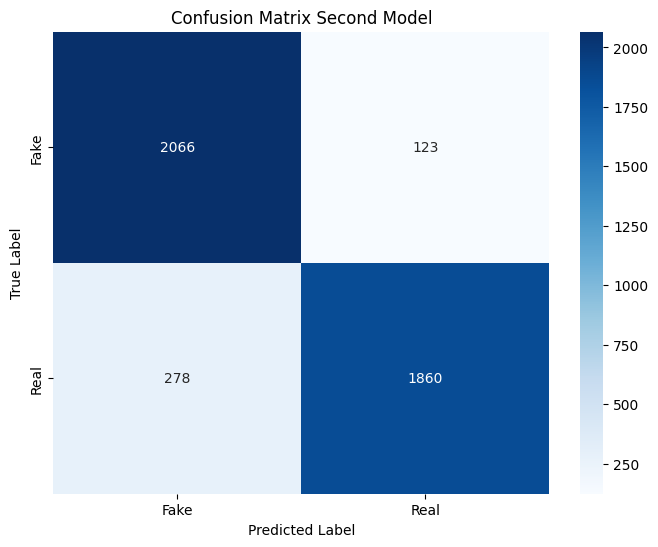

In [47]:
test_predictions = []
true_labels = []
for i in range(len(test_df)):
    test_text = test_df["text"].iloc[i]
    encoding = TOKENIZER.encode_plus(
        test_text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    second_model = second_model.to(device)
    test_prediction = (
        second_model(input_ids, attention_mask).detach().cpu().numpy()
    )
    test_predictions.append(test_prediction)
    true_label = test_df["type"].iloc[i]
    true_labels.append(true_label)

test_predictions = np.array(test_predictions)
true_labels = np.array(true_labels)

print("Classification Report Second Model:")
print(classification_report(true_labels, (test_predictions > 0.5).astype(int)))

cm = confusion_matrix(true_labels, (test_predictions > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Second Model")
plt.show()

* **Note:** The first model did not perform significantly better than simply training a pre-trained model. Although the second model's false negatives are slightly worse, the computational cost and speed of training are the more important values to vote for the second model.

# Parameter Tuning with Optuna:

In [101]:
def evaluate_model(model, dropout_rate):
    model.hparams.dropout_rate = dropout_rate
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1
    )

    result = trainer.test(model, data_container)
    test_loss = result[0]['test_loss']

    return test_loss

def objective(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    existing_model = FakeDetectionModel.load_from_checkpoint(
    best_model_path, n_classes=1
)

    test_loss = evaluate_model(existing_model, dropout_rate)
    return test_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_dropout_rate = study.best_params['dropout_rate']
print("Best dropout rate:", best_dropout_rate)

[I 2024-04-09 20:04:22,146] A new study created in memory with name: no-name-603f3444-da56-4bab-b1f7-bc5282e32b3e
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:05:39,649] Trial 0 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.17949838518461758}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:06:56,517] Trial 1 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.46604553734456755}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:08:13,402] Trial 2 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.20360755434665664}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:09:30,450] Trial 3 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.3093255574621695}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:10:47,190] Trial 4 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.4564370956730376}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:12:04,029] Trial 5 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.3179475981571209}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:13:21,074] Trial 6 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.27566661803550085}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:14:37,782] Trial 7 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.12610779384654314}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:15:55,709] Trial 8 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.40974400410606826}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27915364503860474    │
└───────────────────────────┴───────────────────────────┘

[I 2024-04-09 20:17:12,810] Trial 9 finished with value: 0.27915364503860474 and parameters: {'dropout_rate': 0.32858422121391784}. Best is trial 0 with value: 0.27915364503860474.


[{'test_loss': 0.27915364503860474}]
Best dropout rate: 0.17949838518461758


In [102]:
checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/checkpoints",
    filename="best_tuned_checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)
logger = TensorBoardLogger(
    "/content/drive/MyDrive/fake_logs", name="fake_tuned_detection"
)
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

In [104]:
optimal_dropout_rate = study.best_params['dropout_rate']
model.hparams.dropout_rate = optimal_dropout_rate

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=N_EPOCHS,
    gradient_clip_val=1,
    enable_progress_bar=True
)
trainer.fit(model, data_container)

model.eval()
model.freeze()
trainer.test(model, data_container)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | DistilBertModel   | 65.2 M
1 | pre_classifier | Linear            | 590 K 
2 | dropout        | Dropout           | 0     
3 | classifier     | Linear            | 769   
4 | criterion      | BCEWithLogitsLoss | 0     
-----------------------------------------------------
591 K     Trainable params
65.2 M    Non-trainable params
65.8 M    Total params
263.129   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 3548: 'val_loss' reached 0.26223 (best 0.26223), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 7096: 'val_loss' reached 0.24387 (best 0.24387), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 10644: 'val_loss' reached 0.23130 (best 0.23130), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 14192: 'val_loss' reached 0.21985 (best 0.21985), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 17740: 'val_loss' reached 0.21134 (best 0.21134), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 21288: 'val_loss' reached 0.20509 (best 0.20509), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 24836: 'val_loss' reached 0.20132 (best 0.20132), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 28384: 'val_loss' reached 0.19942 (best 0.19942), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 31932: 'val_loss' reached 0.19813 (best 0.19813), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 35480: 'val_loss' reached 0.19736 (best 0.19736), saving model to '/content/drive/MyDrive/checkpoints/best_tuned_checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model parameters frozen


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1960047334432602     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1960047334432602}]

Classification Report Final Tuned Model:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2189
           1       0.94      0.92      0.93      2138

    accuracy                           0.93      4327
   macro avg       0.93      0.93      0.93      4327
weighted avg       0.93      0.93      0.93      4327



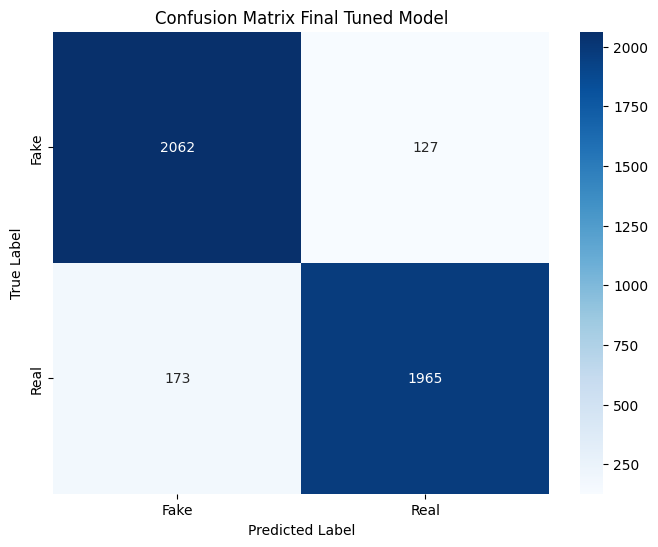

In [106]:
test_predictions = []
true_labels = []
for i in range(len(test_df)):
    test_text = test_df["text"].iloc[i]
    encoding = TOKENIZER.encode_plus(
        test_text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    model = model.to(device)
    test_prediction = (
        model(input_ids, attention_mask).detach().cpu().numpy()
    )
    test_predictions.append(test_prediction)
    true_label = test_df["type"].iloc[i]
    true_labels.append(true_label)

test_predictions = np.array(test_predictions)
true_labels = np.array(true_labels)

print("Classification Report Final Tuned Model:")
print(classification_report(true_labels, (test_predictions > 0.5).astype(int)))

cm = confusion_matrix(true_labels, (test_predictions > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Final Tuned Model")
plt.show()

In [19]:
directory_path = "/content/drive/MyDrive/checkpoints"
best_model_filename = "best_tuned_checkpoint.ckpt"
best_model_path = os.path.join(directory_path, best_model_filename)

In [20]:
tuned_model = FakeDetectionModel.load_from_checkpoint(
    best_model_path, n_classes=1
)
tuned_model.eval()
tuned_model.freeze()

Model parameters frozen


In [21]:
def predict_proba(texts):
    inputs = TOKENIZER(
        texts,
        return_tensors="pt",
        max_length=512,
        padding=True,
        truncation=True,
    )
    tuned_model.eval()
    with torch.no_grad():
        y_pred = tuned_model(**inputs)
        y_pred_negative = 1 - y_pred
        y_pred = y_pred.unsqueeze(1)
        y_pred_negative = y_pred_negative.unsqueeze(1)
        y_pred_concat = torch.cat((y_pred_negative, y_pred), dim=1)
    probabilities = torch.softmax(y_pred_concat, dim=1)
    return probabilities.cpu().numpy()

In [22]:
random_index = 654

test_text = test_df['text'].iloc[random_index]
real_label = test_df['type'].iloc[random_index]

In [23]:
tuned_model.cpu()
explainer = LimeTextExplainer(class_names=["Fake_News", "Real_News"])
exp = explainer.explain_instance(test_text, predict_proba, num_features=3)

probabilities = predict_proba(test_text)
print("Probability(fake news) =", probabilities[0, 0])
print("Probability(real news) =", probabilities[0, 1])
print("True class: %s" % real_label.item())

plt.figure(figsize=(10, 6))
exp.show_in_notebook(text=False)

Probability(fake news) = 0.99643886
Probability(real news) = 0.0035611738
True class: 0


<Figure size 1000x600 with 0 Axes>

In [29]:
random_index = 698

test_text = test_df['text'].iloc[random_index]
real_label = test_df['type'].iloc[random_index]
print(test_text)

nigerian   president   likens   myanmar   crisis   to   bosnia   rwanda   genocides   nigerian   president   muhammadu   buhari   on   tuesday   likened   the   violence   in   myanmar   against   rohingya   muslims   to   genocides   in   bosnia   and   rwanda   urging   a   halt   to   the   ongoing   ethnic   cleansing   and   safe   return   of   refugees   the   myanmar   crisis   is   very   reminiscent   of   what   happened   in   bosnia   in   1995   and   in   rwanda   in   1994   buhari   told   the   annual   gathering   of   world   leaders   at   the   united   nations   he   added   that   the   horrendous   suffering   had   been   caused   by   state   backed   program   of   brutal   depopulation   of   the   rohingya   inhabited   areas   in   myanmar   on   the   bases   of   ethnicity   and   religion


In [30]:
tuned_model.cpu()
explainer = LimeTextExplainer(class_names=["Fake_News", "Real_News"])
exp = explainer.explain_instance(test_text, predict_proba, num_features=3)

probabilities = predict_proba(test_text)
print("Probability(fake news) =", probabilities[0, 0])
print("Probability(real news) =", probabilities[0, 1])
print("True class: %s" % real_label.item())

plt.figure(figsize=(12, 8))
exp.show_in_notebook(text=False)

Probability(fake news) = 0.011874218
Probability(real news) = 0.9881258
True class: 1


<Figure size 1200x800 with 0 Axes>

**Conclusions:**
- The main issue has been the database itself. One part was the real news as articles published by Reuters. In principle, these are articles that have been edited several times and have almost lost their individuality, which is quite important for textual classification. In this case, I have removed all references to this news agency in order to reduce the bias. The second part of the database (of fake news) is the statements and comments in the social network (I can guess from the general structure of the statements). This part is highly individualized and linguistically it would be easy to predict authorship. Overall, therefore, I could conclude that these two dataset parts are hardly comparable.
- In order to eliminate bias, I have tried to remove certain items (special characters). At the same time I have tried to keep a few most common features  in fake news: upper cased words, exclamation marks and multiple dots. Linguistically, these items are mostly used to give special emphasis to the content, and since the aim is to identify fake news, I think this choice has justified the effort.
- For the modelling of this part, I did not try to drastically clean up the text, trying to leave as much as possible of the natural language aspects for the teaching of the model. Therefore, I did not try to remove the personal names or the days of the week, I did not remove the stop words, because they add to the perceptual value of the text.
- Out of 2 models that were made for this part of project the model with pretrained Distilbert model and added layers (Linear(768, 768), Dropout(0.2), Linear(768, 1)) was a beeter option for training speed and computational cost. Trained for 10 epochs model gave test loss 0.279.
- For Dropout rate Optuna was used and final model gave test loss 0.196.
- Overall tuned model gave better results compared with ML Logistic regression model if we compare False Negative results. Logistic Regresion gave 560 false news predicted as real ones and DL model gave 127 false news as negatives.

**Improvements**:
- Further study of new tools, modules and research achievements in DL classification field is needed to improve the results;
- The number of training epochs, which has been low due to lack of time, should be increased (initial 10 epochs was a clear indication that results could be improved);
- It would also be worth studying the semantics of the language, or at least it would not hurt to have the advice of a specialist in order to be able to clarify data features  and to reduce the costs of the production.

Thank you.